In [ ]:
# floyd run --gpu --env mxnet \
# --data wctttty/projects/gw_colored_classification/132/output:dataset \
# --data wctttty/projects/gw_colored_classification/216/output:params \
# --data wctttty/datasets/gw_colored8192/2:GW_data \
# --data wctttty/datasets/ligonose9_9000_8192/7:noise1 \
# --data wctttty/datasets/ligonose9_9000_8192/6:noise2 \
# --message 'Visualization for the proformace of params_avg_max' \
# --mode jupyter

In [1]:
!pip install --upgrade pip
!pip install seaborn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/site-packages (10.0.1)
thinc 6.10.2 has requirement cytoolz<0.9,>=0.8, but you'll have cytoolz 0.9.0 which is incompatible.
spacy 2.0.5 has requirement requests<3.0.0,>=2.13.0, but you'll have requests 2.10.0 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/10/01/dd1c7838cde3b69b247aaeb61016e238cafd8188a276e366d36aa6bcdab4/seaborn-0.8.1.tar.gz
  Running setup.py bdist_wheel for seaborn ... done
  Stored in directory: /root/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn
thinc 6.10.2 has requirement cytoolz<0.9,>=0.8, but you'll have cytoolz 0.9.0 which is incompatible.
spacy 2.0.5 has requirement requests<3.0.0,>=2.13.0, but you'll have requests 2.10.0 which is incompatible.


In [1]:
!ls

1CONV		     AUC_activation.npy       num_filter2
2CONV		     AUC_dilate.npy	      oneMLP_128
2MLP		     AUC_model.npy	      oneMLP_32
3MLP		     AUC_num_fc.eps	      params_23.dms
AUC_AVG&MAX.npy      PRL		      params_PLB_32.dms
AUC_SNR.eps	     SNR_MF.eps		      params_PRL_23.dms
AUC_SNR_AVG&MAX.eps  Untitled.ipynb	      params_dilate2_82.dms
AUC_SNR_dilate.eps   dropout0_5		      params_elu.dms
AUC_SNR_model.eps    fine_tune_MyModel.ipynb
AUC_activation.eps   num_filter1_2


In [2]:
# importing the library
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import signal
import scipy
import math
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.gridspec import GridSpec
%matplotlib inline 

import time
import os, sys

In [3]:
# import OpenSSL.SSL
from __future__ import print_function
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

try:
    ctx = mx.gpu()
    _ = nd.zeros((1,), ctx=ctx)
except:
    ctx = mx.cpu()
print('CPU or GPU? : ', ctx)

CPU or GPU? :  gpu(0)


In [4]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params(num_fc, num_outputs, sl, nf):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(16*nf), 1, 1, 16), ctx=ctx )
    W2 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(32*nf), int(16*nf), 1, 8), ctx=ctx )
    W3 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(32*nf), 1, 8), ctx=ctx )
    W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(sl, num_fc), ctx=ctx )
    W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
    b1 = nd.random_normal(shape=int(16*nf), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=int(32*nf), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
    b5 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs

import sys
sys.path.append('..')
# import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import loss as gloss

def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃。
    if keep_prob == 0:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape, ctx=ctx) < keep_prob
    return mask * X / keep_prob

# CNN model
def net(X, params, debug=False, pool_type='avg',pool_size = 16,pool_stride=2, act_type = 'relu', dilate_size = 1, nf=1):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=int(16*nf), stride=(1,1),dilate=(1,dilate_size))
    h1_activation = activation(h1_conv, act_type = act_type)
    h1 = nd.Pooling(data=h1_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=int(32*nf), stride=(1,1),dilate=(1,dilate_size))
    h2_activation = activation(h2_conv, act_type = act_type)
    h2 = nd.Pooling(data=h2_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h3_activation = activation(h3_conv, act_type = act_type)
    h3 = nd.Pooling(data=h3_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h4 = nd.flatten(h3)
    if debug:
        print("Flat h4 shape: %s" % (np.array(h4.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h5_linear = nd.dot(h4, W4) + b4
    h5 = activation(h5_linear, act_type = act_type)
    if autograd.is_training():
        # 对激活函数的输出使用droupout
        h5 = dropout(h5, drop_prob)
    if debug:
        print("h5 shape: %s" % (np.array(h5.shape)))
        print("Dropout: ", drop_prob)

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h5, W5) + b5
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5]
    
    return yhat_linear, interlayer

# Non-linear function.
def relu(X):
    return nd.maximum(X,nd.zeros_like(X))

# Activation type
def activation(X, act_type = 'relu'):
    if act_type == 'relu':
        return nd.maximum(X,nd.zeros_like(X))
    elif act_type == 'elu':
        return nd.LeakyReLU(X, act_type=act_type)
    else:
        print('Something wrong with the act_type!')

# Loss function.
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    partition = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

def transform_softmax(x):
    max_of_dim1 =nd.max(x,axis=1,keepdims=True)
    return (nd.exp(x-max_of_dim1).T/nd.exp(x-max_of_dim1).sum(axis=1,keepdims=True).T).T

def softmax_cross_entropy(yhat_linear, y):   # 交叉熵损失
    # return - nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)
    return - nd.nansum(y * nd.log(transform_softmax(yhat_linear)), axis=0, exclude=True)

def evaluate_accuracy(data_iterator, num_examples, batch_size, params, net, pool_type,pool_size,pool_stride, act_type, dilate_size, nf):
    numerator = 0.
    denominator = 0.
    for batch_i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output, _ = net(data, params,pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                        , act_type= act_type, dilate_size = dilate_size,nf=nf)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        print('Evaluating accuracy. (complete percent: %.2f/100' %(1.0 * batch_i / (num_examples//batch_size) * 100) +')' , end='')
        sys.stdout.write("\r")
    return (numerator / denominator).asscalar()

# Mini-batch stochastic gradient descent.
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
        
# Adam.
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        g = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * g
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)
        param[:] = param - div

def Train(train, test, Debug, batch_size, lr
          , smoothing_constant, num_fc, num_outputs, epochs, SNR
          , sl, pool_type ,pool_size ,pool_stride, act_type = 'relu' , dilate_size = 1, nf = 1
          , params_init=None, period=None, **kwargs):
    if kwargs:
        net = kwargs['net']
        init_params = kwargs['init_params']

    num_examples = train.shape[0]
    # 训练集数据类型转换
    y = nd.array(~train.sigma.isnull() +0)
    X = nd.array(Normolise(train.drop(['mass','positions','gaps','max_peak','sigma','SNR_mf','SNR_mf0'],axis=1)))
    print('Label for training:', y.shape)
    print('Dataset for training:', X.shape, end='\n\n')

    dataset_train = gluon.data.ArrayDataset(X, y)
    train_data = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='discard')

    y = nd.array(~test.sigma.isnull() +0)
    X = nd.array(Normolise(test.drop(['mass','positions','gaps','max_peak','sigma','SNR_mf','SNR_mf0'],axis=1)))
    print('Label for testing:', y.shape)
    print('Dataset for testing:', X.shape, end='\n\n')
    
    # 这里使用data模块来读取数据。创建测试数据。  (不shuffle)
    dataset_test = gluon.data.ArrayDataset(X, y)
    test_data = gluon.data.DataLoader(dataset_test, batch_size, shuffle=True, last_batch='discard')

    
    # Train
    loss_history = []
    loss_v_history = []
    moving_loss_history = []
    test_accuracy_history = []
    train_accuracy_history = []
    
#     assert period >= batch_size and period % batch_size == 0
    
    # Initializate parameters
    if params_init:
        print('Loading params...')
        params = params_init

        [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5] = params

        # random fc layers
        weight_scale = .01
        W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(64256, num_fc), ctx=ctx )
        W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
        b4 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
        b5 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

        params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5]
        print('Random the FC-layers...')

        vs = []
        sqrs = [] 
        for param in params:
            param.attach_grad()
            vs.append(param.zeros_like())
            sqrs.append(param.zeros_like())
    else:
        params, vs, sqrs = init_params(num_fc = num_fc, num_outputs = 2, sl=sl, nf=nf)
        print('Initiate weights from random...')
        
    # Debug
    if Debug:
        print('Debuging...')
        if params_init:
            params = params_init
        else:
            params, vs, sqrs = init_params(num_fc = num_fc, num_outputs = 2, sl=sl, nf=nf)
        for data, _ in train_data:
            data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
            break
        _, _ = net(data, params, debug=Debug, pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                   , act_type = act_type, dilate_size = dilate_size, nf=nf)
        print()    
    
#     total_loss = [Total_loss(train_data_10, params, batch_size, num_outputs)]
    
    t = 0
#   Epoch starts from 1.
    print('pool_type: ', pool_type)
    print('pool_size: ', pool_size)
    print('pool_stride: ', pool_stride)
    print('sl: ', sl)
    print('act_type: ', act_type)
    print('dilate_size: (1, %s)' %str(dilate_size) )
    print('num_filter: ', nf)
    for epoch in range(1, epochs + 1):
        Epoch_loss = []
#         学习率自我衰减。
#         if epoch > 2:
#             lr *= 0.1
        for batch_i, ((data, label),(data_v, label_v)) in enumerate(zip(train_data, test_data)):
            data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
            label = label.as_in_context(ctx)
            label_one_hot = nd.one_hot(label, num_outputs)
            with autograd.record():
                output, _ = net(data, params, pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                                , act_type = act_type, dilate_size = dilate_size, nf=nf)
                loss = softmax_cross_entropy(output, label_one_hot)
            loss.backward()
#             print(output)
#             sgd(params, lr, batch_size)

#           Increment t before invoking adam.
            t += 1
            adam(params, vs, sqrs, lr, batch_size, t)

            data_v = data_v.as_in_context(ctx).reshape((batch_size,1,1,-1))
            label_v = label_v.as_in_context(ctx)
            label_v_one_hot = nd.one_hot(label_v, num_outputs)
            output_v, _ = net(data_v, params, pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                              , act_type = act_type, dilate_size = dilate_size, nf=nf)
            loss_v = softmax_cross_entropy(output_v, label_v_one_hot)            
            
#             #########################
#              Keep a moving average of the losses
#             #########################
            curr_loss = nd.mean(loss).asscalar()
            curr_loss_v = nd.mean(loss_v).asscalar()
            moving_loss = (curr_loss if ((batch_i == 0) and (epoch-1 == 0))
                           else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

            loss_history.append(curr_loss)
            loss_v_history.append(curr_loss_v)
            moving_loss_history.append(moving_loss)
            Epoch_loss.append(curr_loss)
#             if batch_i * batch_size % period == 0:
#                 print('Curr_loss: ', curr_loss)
                
            print('Working on epoch %d. Curr_loss: %.5f (complete percent: %.2f/100' %(epoch, curr_loss*1.0, 1.0 * batch_i / (num_examples//batch_size) * 100) +')' , end='')
            sys.stdout.write("\r")
            # print('{"metric": "Training Loss for ALL", "value": %.5f}' %(curr_loss*1.0) )
            # print('{"metric": "Testing Loss for ALL", "value": %.5f}' %(curr_loss_v*1.0) )
#             print('{"metric": "Training Loss for SNR=%s", "value": %.5f}' %(str(SNR), curr_loss*1.0) )
#             print('{"metric": "Testing Loss for SNR=%s", "value": %.5f}' %(str(SNR), curr_loss_v*1.0) )
        test_accuracy = evaluate_accuracy(test_data, num_examples, batch_size, params, net,pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                                          , act_type = act_type, dilate_size = dilate_size,nf=nf)
        train_accuracy = evaluate_accuracy(train_data, num_examples, batch_size, params, net,pool_type=pool_type,pool_size = pool_size,pool_stride=pool_stride
                                           , act_type = act_type, dilate_size = dilate_size,nf=nf)
        test_accuracy_history.append(test_accuracy)
        train_accuracy_history.append(train_accuracy)


        print("Epoch %d, Moving_loss: %.6f, Epoch_loss(mean): %.6f, Train_acc %.4f, Test_acc %.4f" %
              (epoch, moving_loss, np.mean(Epoch_loss), train_accuracy, test_accuracy))
#         print('{"metric": "Train_acc. for SNR=%s in epoches", "value": %.4f}' %(str(SNR), train_accuracy) )
#         print('{"metric": "Test_acc. for SNR=%s in epoches", "value": %.4f}' %(str(SNR), test_accuracy) )
        yield (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history)




def mkdir_checkdir(path = "/output"):
    isExists = os.path.exists(path)
    if not isExists:
        os.mkdir(path)
        print('MKDIR: ' + path + ' successful!')
    else:
        print(path + " have existed!")

In [5]:
import urllib
url  = 'https://dcc.ligo.org/public/0002/T0900288/003/ZERO_DET_high_P.txt'
raw_data=urllib.request.urlopen(url)
ZERO_DET = np.loadtxt(raw_data)

def noise_psd(noise_sample, lensample, fs,low_pass = 20):
	fs = 8192
	NFFT = fs//8
	NOVL = NFFT/2
	noise_sample = np.array(noise_sample)
	psd_window = np.blackman(NFFT)
	data_freqs = np.fft.fftfreq(lensample) * fs
	power_vec_, freqs_ = mlab.psd(noise_sample, Fs = fs, NFFT = NFFT, window=psd_window
                                  , noverlap=NOVL ,sides='onesided')
	slc = (freqs_>low_pass) #& (freqs_<high_pass)
	return np.interp(np.abs(data_freqs), freqs_[slc], power_vec_[slc])

def noise_psd_zero(ZERO_DET, lensample,fs = 8192,low_pass = 20):
	data_freqs = np.fft.fftfreq(lensample) * fs
	slc = (ZERO_DET[:,0]>=low_pass)# & (ZERO_DET[:,0]<=high_pass)
	asd_zero = np.interp(np.abs(data_freqs)
                         , ZERO_DET[:,0][slc]
                         , ZERO_DET[:,1][slc])
	return asd_zero**2

def SNR_MF(data, noise_sample, signal, GW_train_shape, own_noise=1, fs=8192, low_pass=20):
    lensample = data.shape[1]
    try: # Tukey window preferred, but requires recent scipy version 
        dwindow = scipy.signal.get_window(('tukey',1./8),lensample)
    except: # Blackman window OK if Tukey is not available
        dwindow = scipy.signal.get_window('blackman',lensample) 
        print('No tukey windowing, using blackman!')    
    # FFT
    data_freqs = np.fft.fftfreq(lensample) * fs
    FFT_data = np.fft.fft(data*dwindow) /fs
    FFT_signal = np.fft.fft(signal*dwindow) /fs
    
    SNR_mf = np.array([])
    for i in range(GW_train_shape):
        # PSD of noise
        if own_noise == 1: power_vec = noise_psd(noise_sample[i,:], lensample, fs,low_pass = low_pass)
        elif own_noise == 0: power_vec = noise_psd_zero(ZERO_DET, lensample,fs = 8192,low_pass = 20)
        optimal = FFT_data[i,:] * FFT_signal[i,:].conjugate() / power_vec
        optimal_time = 2*np.fft.ifft(optimal) * fs

        # -- Normalize the matched filter output
        df = np.abs(data_freqs[1] - data_freqs[0]) # also df=nsample/fs
        sigmasq = 1*(FFT_signal[i,:] * FFT_signal[i,:].conjugate() / power_vec).sum() * df
        sigma0 = np.sqrt(np.abs(sigmasq))
        SNR_complex = (optimal_time) / (sigma0)
        SNR_mf = np.append(SNR_mf, np.max(np.abs(SNR_complex)))
    return SNR_mf

In [6]:
def Normolise(data):
	data_array = np.array(data)
	data_array_shape = data_array.shape[0]
	return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
						,index = data.index)


def pos_gap(samples):
	positions = []
	gaps = []
	for sam in samples.values.tolist():
		position = [index for index, value in enumerate(sam) if (sam[index-1] * sam[index]  < 0) & (index != 0)]
		gaps.append([position[i+1] - j for i,j in enumerate(position) if j != position[-1] ])
		positions.append(position)
	return positions, gaps



def creat_data(GW_train, noise1, SNR):
	# GW_train = Normolise(GW_train)
	noise1array = np.array(noise1)
	GW_train_shape = GW_train.shape[0]
	GW_train_index = GW_train.index
	positions, gaps = pos_gap(Normolise(GW_train))
	max_peak = GW_train.max(axis=1)
	
	sigma = GW_train.max(axis=1) / float(SNR) / noise1array[:GW_train_shape,:].std(axis=1)
	# data = GW_train + np.multiply(noise1array[:GW_train_shape,:], sigma.reshape((GW_train_shape,-1)) )
	signal = GW_train.div(sigma, axis=0)
	data = signal + noise1array[:GW_train_shape,:]
	SNR_mf = SNR_MF(data=data, noise_sample=noise1array[:GW_train_shape,:], signal=signal
                    ,own_noise=1,GW_train_shape=GW_train_shape
                    , fs=8192, low_pass=20)
	data['SNR_mf0'] = SNR_MF(data=data, noise_sample=noise1array[:GW_train_shape,:], signal=signal
                             ,own_noise=0,GW_train_shape=GW_train_shape
                             , fs=8192, low_pass=20)
	data['SNR_mf'] = SNR_mf

	data['mass'] = GW_train_index
	data['positions'] , data['gaps'] = positions, gaps
	data['max_peak'] = max_peak
	data['sigma'] = sigma

	i = 1
	while (i+1)*GW_train_shape <= noise1array.shape[0]:
		noise1array_p = noise1array[i*GW_train_shape:(i+1)*GW_train_shape,:]

		sigma = GW_train.max(axis=1) / float(SNR) / noise1array_p[:GW_train_shape,:].std(axis=1)
		# data_new = GW_train + np.multiply(noise1array_p[:GW_train_shape,:], sigma.reshape((GW_train_shape,-1)) )
		data_new = GW_train.div(sigma, axis=0) + noise1array_p[:GW_train_shape,:]

		data_new['mass'] = GW_train_index
		data_new['positions'] , data_new['gaps'] = positions, gaps
		data_new['max_peak'] = max_peak
		data_new['sigma'] = sigma
		data = pd.concat([data, data_new ])
		i+=1
		print('Loop! ',i-1 , end='')
# 		print('{"metric": "LOOP for SNR=%s", "value": %d}' %(str(SNR), int(i-1)) )
		sys.stdout.write("\r")
	return data

In [7]:
data_GW_train = pd.read_csv('../GW_data/GW_train_full.csv', index_col=0)
print('The shape of data_GW_train: ' , data_GW_train.shape)

noise1 = pd.read_csv('../noise1/LigoNose9_9000_8192_1.csv', index_col=0)
print('The shape of the noise1: ', noise1.shape)

noise_train = pd.read_csv('../noise2/LigoNose9_9000_8192_3.csv', index_col=0)
print('The shape of the noise_train: ', noise_train.shape)

data_GW_test = pd.read_csv('../GW_data/GW_test_full.csv', index_col=0)
print('The shape of data_GW_test: ' , data_GW_test.shape)

noise2 = pd.read_csv('../noise1/LigoNose9_9000_8192_2.csv', index_col=0)
print('The shape of the noise2: ', noise2.shape)

noise_test = pd.read_csv('../noise2/LigoNose9_9000_8192_4.csv', index_col=0)
print('The shape of the noise_test: ', noise_test.shape)

The shape of data_GW_train:  (704, 8192)
The shape of the noise1:  (10000, 8192)
The shape of the noise_train:  (10000, 8192)
The shape of data_GW_test:  (736, 8192)
The shape of the noise2:  (10000, 8192)
The shape of the noise_test:  (10000, 8192)


In [8]:
data_train = creat_data(data_GW_train, noise1, 1)
data_test = creat_data(data_GW_test, noise2, 1)
print(data_train.shape)
print(data_test.shape)

(9856, 8199)
(9568, 8199)


In [9]:
batch_size = 256
sampling_freq = 8192
colomns = [ str(i) for i in range(sampling_freq)] + ['mass','positions','gaps','max_peak','sigma','SNR_mf','SNR_mf0']

train_dict = {}
test_dict = {}
train_dict['%s' %str(1)] = pd.concat([data_train, noise_train.iloc[:data_train.shape[0],:]])[colomns]
test_dict['%s' %str(1)] = pd.concat([data_test, noise_test.iloc[:data_test.shape[0],:]])[colomns]
print(train_dict['1'].shape)
print(test_dict['1'].shape)

(19712, 8199)
(19136, 8199)


In [10]:
del data_GW_train, data_GW_test, noise1, noise2, noise_train, noise_test, data_train, data_test

# one MLP 32 128

In [32]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 64256
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 128
address = 'oneMLP_128'
mkdir_checkdir(path = "./%s" %address)

./oneMLP_128 have existed!


In [33]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = 1
             , num_fc = num_fc, num_outputs = 2, period = 256)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
Flat h4 shape: [  256 64256]
h4 shape: [256 128]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  64256
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.537524, Epoch_loss(mean): 0.445553, Train_acc 0.9594, Test_acc 0.9492
Epoch 2, Moving_loss: 0.315287, Epoch_loss(mean): 0.117449, Train_acc 0.9912, Test_acc 0.9889
Epoch 3, Moving_loss: 0.160478, Epoch_loss(mean): 0.022197, Train_acc 0.9967, Test_acc 0.9965
Epoch 4, Moving_loss: 0.080848, Epoch_loss(mean): 0.009172, Train_acc 0.9985, Test_acc 0.9982
Epoch 5, Moving_loss: 0.045417, Epoch_loss(mean): 0.012453, Train_acc 0.9942, Test_acc 0.9933
Epoch 6, Moving_loss: 0.026151, Epoch_loss

KeyboardInterrupt: 

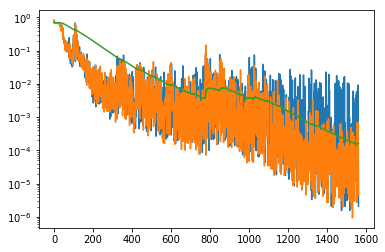

In [34]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# nf 1/2  2

In [15]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 32128
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1/2
# 32128 1/2
# 128512 2
# 257024 4
address = 'num_filter1_2'
mkdir_checkdir(path = "./%s" %address)

./num_filter1_2 have existed!


In [16]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256    8    1 4081]
h2 shape: [ 256   16    1 2030]
h3 shape: [ 256   32    1 1004]
Flat h4 shape: [  256 32128]
h4 shape: [256  64]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  32128
act_type:  relu
dilate_size: (1, 1)
num_filter:  0.5
Epoch 1, Moving_loss: 0.550752, Epoch_loss(mean): 0.471874, Train_acc 0.9744, Test_acc 0.9706
Epoch 2, Moving_loss: 0.304362, Epoch_loss(mean): 0.083513, Train_acc 0.9787, Test_acc 0.9724
Epoch 3, Moving_loss: 0.176243, Epoch_loss(mean): 0.060133, Train_acc 0.9852, Test_acc 0.9800
Epoch 4, Moving_loss: 0.114358, Epoch_loss(mean): 0.055964, Train_acc 0.9713, Test_acc 0.9645
Epoch 5, Moving_loss: 0.073359, Epoch_loss(mean): 0.037156, Train_acc 0.9914, Test_acc 0.9893
Epoch 6, Moving_loss: 0.100396, Epoch_lo

KeyboardInterrupt: 

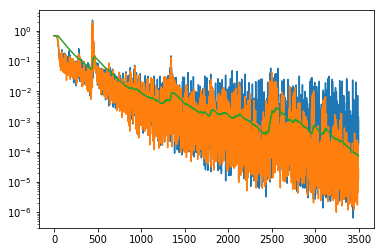

In [17]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# two MLP

In [45]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params_2MLP(num_fc, num_outputs, sl, nf):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(16*nf), 1, 1, 16), ctx=ctx )
    W2 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(32*nf), int(16*nf), 1, 8), ctx=ctx )
    W3 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(32*nf), 1, 8), ctx=ctx )
    W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(sl, num_fc), ctx=ctx )
    W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_fc), ctx=ctx )    
    W6 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
    b1 = nd.random_normal(shape=int(16*nf), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=int(32*nf), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
    b5 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)    
    b6 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs


# CNN model
def net_2MLP(X, params, debug=False, pool_type='avg',pool_size = 16,pool_stride=2, act_type = 'relu', dilate_size = 1, nf=1):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=int(16*nf), stride=(1,1),dilate=(1,dilate_size))
    h1_activation = activation(h1_conv, act_type = act_type)
    h1 = nd.Pooling(data=h1_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=int(32*nf), stride=(1,1),dilate=(1,dilate_size))
    h2_activation = activation(h2_conv, act_type = act_type)
    h2 = nd.Pooling(data=h2_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h3_activation = activation(h3_conv, act_type = act_type)
    h3 = nd.Pooling(data=h3_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h4 = nd.flatten(h3)
    if debug:
        print("Flat h4 shape: %s" % (np.array(h4.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h5_linear = nd.dot(h4, W4) + b4
    h5 = activation(h5_linear, act_type = act_type)
    if debug:
        print("h5 shape: %s" % (np.array(h5.shape)))

    ########################
    #  Define the computation of the 5th (fully-connected) layer
    ########################
    h6_linear = nd.dot(h5, W5) + b5
    h6 = activation(h6_linear, act_type = act_type)
    if debug:
        print("h6 shape: %s" % (np.array(h6.shape)))

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h6, W6) + b6
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5, h6]
    
    return yhat_linear, interlayer

In [46]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 64256
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1
# 32128 1/2
# 128512 2
# 257024 4
address = '2MLP'
mkdir_checkdir(path = "./%s" %address)

./2MLP have existed!


In [47]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256, net=net_2MLP, init_params=init_params_2MLP)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
Flat h4 shape: [  256 64256]
h5 shape: [256  64]
h6 shape: [256  64]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  64256
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.455658, Epoch_loss(mean): 0.282868, Train_acc 0.9785, Test_acc 0.9712
Epoch 2, Moving_loss: 0.280626, Epoch_loss(mean): 0.139928, Train_acc 0.9880, Test_acc 0.9851
Epoch 3, Moving_loss: 0.142182, Epoch_loss(mean): 0.018895, Train_acc 0.9981, Test_acc 0.9975
Epoch 4, Moving_loss: 0.071061, Epoch_loss(mean): 0.006672, Train_acc 0.9787, Test_acc 0.9771
Epoch 5, Moving_loss: 0.135780, Epoch_loss(mean): 0.237423, Train_acc 0.9910, Test_acc 0.9904
Epoch 6, Moving_loss: 

KeyboardInterrupt: 

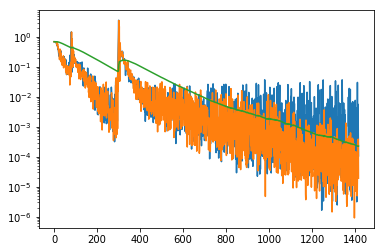

In [48]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# three MLP

In [49]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params_3MLP(num_fc, num_outputs, sl, nf):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(16*nf), 1, 1, 16), ctx=ctx )
    W2 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(32*nf), int(16*nf), 1, 8), ctx=ctx )
    W3 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(32*nf), 1, 8), ctx=ctx )
    W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(sl, num_fc), ctx=ctx )
    W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_fc), ctx=ctx )    
    W6 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_fc), ctx=ctx )        
    W7 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
    b1 = nd.random_normal(shape=int(16*nf), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=int(32*nf), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
    b5 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)    
    b6 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)        
    b7 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs


# CNN model
def net_3MLP(X, params, debug=False, pool_type='avg',pool_size = 16,pool_stride=2, act_type = 'relu', dilate_size = 1, nf=1):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=int(16*nf), stride=(1,1),dilate=(1,dilate_size))
    h1_activation = activation(h1_conv, act_type = act_type)
    h1 = nd.Pooling(data=h1_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=int(32*nf), stride=(1,1),dilate=(1,dilate_size))
    h2_activation = activation(h2_conv, act_type = act_type)
    h2 = nd.Pooling(data=h2_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h3_activation = activation(h3_conv, act_type = act_type)
    h3 = nd.Pooling(data=h3_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h4 = nd.flatten(h3)
    if debug:
        print("Flat h4 shape: %s" % (np.array(h4.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h5_linear = nd.dot(h4, W4) + b4
    h5 = activation(h5_linear, act_type = act_type)
    if debug:
        print("h5 shape: %s" % (np.array(h5.shape)))

    ########################
    #  Define the computation of the 5th (fully-connected) layer
    ########################
    h6_linear = nd.dot(h5, W5) + b5
    h6 = activation(h6_linear, act_type = act_type)
    if debug:
        print("h6 shape: %s" % (np.array(h6.shape)))
        
    ########################
    #  Define the computation of the 6th (fully-connected) layer
    ########################
    h7_linear = nd.dot(h6, W6) + b6
    h7 = activation(h7_linear, act_type = act_type)
    if debug:
        print("h7 shape: %s" % (np.array(h7.shape)))        

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h7, W7) + b7
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5, h6, h7]
    
    return yhat_linear, interlayer

In [50]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 64256
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1
# 32128 1/2
# 128512 2
# 257024 4
address = '3MLP'
mkdir_checkdir(path = "./%s" %address)

MKDIR: ./3MLP successful!


In [51]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256, net=net_3MLP, init_params=init_params_3MLP)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
Flat h4 shape: [  256 64256]
h5 shape: [256  64]
h6 shape: [256  64]
h7 shape: [256  64]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  64256
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.590939, Epoch_loss(mean): 0.508922, Train_acc 0.8210, Test_acc 0.8156
Epoch 2, Moving_loss: 0.324934, Epoch_loss(mean): 0.101245, Train_acc 0.9917, Test_acc 0.9935
Epoch 3, Moving_loss: 0.162692, Epoch_loss(mean): 0.016243, Train_acc 0.9958, Test_acc 0.9961
Epoch 4, Moving_loss: 0.082696, Epoch_loss(mean): 0.010343, Train_acc 0.9977, Test_acc 0.9978
Epoch 5, Moving_loss: 0.047090, Epoch_loss(mean): 0.014025, Train_acc 0.9961, Test_acc 0.9962
Ep

KeyboardInterrupt: 

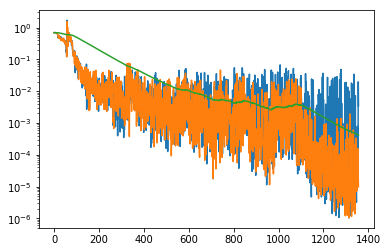

In [52]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# one more CONV

In [58]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params1CONV(num_fc, num_outputs, sl, nf):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(16*nf), 1, 1, 16), ctx=ctx )
    W2 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(32*nf), int(16*nf), 1, 8), ctx=ctx )
    W3 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(32*nf), 1, 8), ctx=ctx )
    W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(64*nf), 1, 8), ctx=ctx )
    W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(sl, num_fc), ctx=ctx )
    W6 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
    b1 = nd.random_normal(shape=int(16*nf), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=int(32*nf), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)    
    b5 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
    b6 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs


# CNN model
def net1CONV(X, params, debug=False, pool_type='avg',pool_size = 16,pool_stride=2, act_type = 'relu', dilate_size = 1, nf=1):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=int(16*nf), stride=(1,1),dilate=(1,dilate_size))
    h1_activation = activation(h1_conv, act_type = act_type)
    h1 = nd.Pooling(data=h1_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=int(32*nf), stride=(1,1),dilate=(1,dilate_size))
    h2_activation = activation(h2_conv, act_type = act_type)
    h2 = nd.Pooling(data=h2_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h3_activation = activation(h3_conv, act_type = act_type)
    h3 = nd.Pooling(data=h3_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))
        
    ########################
    #  Define the computation of the 4th convolutional layer
    ########################
    h4_conv = nd.Convolution(data=h3, weight=W4, bias=b4, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h4_activation = activation(h4_conv, act_type = act_type)
    h4 = nd.Pooling(data=h4_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h4 shape: %s" % (np.array(h4.shape)))
        

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h5 = nd.flatten(h4)
    if debug:
        print("Flat h5 shape: %s" % (np.array(h5.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h6_linear = nd.dot(h5, W5) + b5
    h6 = activation(h6_linear, act_type = act_type)
    if debug:
        print("h6 shape: %s" % (np.array(h6.shape)))

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h6, W6) + b6
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5, h6]
    
    return yhat_linear, interlayer



In [61]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 31424
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1
# 32128 1/2
# 128512 2
# 257024 4
address = '1CONV'
# 31424
mkdir_checkdir(path = "./%s" %address)

./1CONV have existed!


In [62]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256, net=net1CONV, init_params=init_params1CONV)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
h4 shape: [256  64   1 491]
Flat h5 shape: [  256 31424]
h6 shape: [256  64]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  31424
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.500544, Epoch_loss(mean): 0.374246, Train_acc 0.9818, Test_acc 0.9823
Epoch 2, Moving_loss: 0.256842, Epoch_loss(mean): 0.040186, Train_acc 0.9853, Test_acc 0.9843
Epoch 3, Moving_loss: 0.130620, Epoch_loss(mean): 0.016684, Train_acc 0.9970, Test_acc 0.9968
Epoch 4, Moving_loss: 0.066331, Epoch_loss(mean): 0.008154, Train_acc 0.9976, Test_acc 0.9984
Epoch 5, Moving_loss: 0.035683, Epoch_loss(mean): 0.008123, Train_acc 0.9978, Test_acc 0.9975
Epoch 6, Movin

KeyboardInterrupt: 

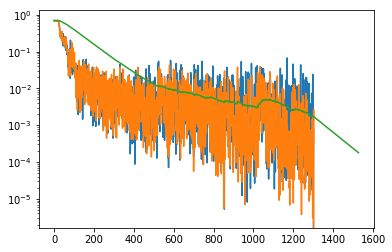

In [63]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# two more CONV

In [64]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params2CONV(num_fc, num_outputs, sl, nf):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(16*nf), 1, 1, 16), ctx=ctx )
    W2 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(32*nf), int(16*nf), 1, 8), ctx=ctx )
    W3 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(32*nf), 1, 8), ctx=ctx )
    W4 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(64*nf), 1, 8), ctx=ctx )
    W5 = nd.random_normal(loc=0, scale=weight_scale, shape=(int(64*nf), int(64*nf), 1, 8), ctx=ctx )    
    W6 = nd.random_normal(loc=0, scale=weight_scale, shape=(sl, num_fc), ctx=ctx )
    W7 = nd.random_normal(loc=0, scale=weight_scale, shape=(num_fc, num_outputs), ctx=ctx )
    b1 = nd.random_normal(shape=int(16*nf), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=int(32*nf), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b5 = nd.random_normal(shape=int(64*nf), scale=weight_scale, ctx=ctx)
    b6 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)
    b7 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs


# CNN model
def net2CONV(X, params, debug=False, pool_type='avg',pool_size = 16,pool_stride=2, act_type = 'relu', dilate_size = 1, nf=1):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W7, b7] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=int(16*nf), stride=(1,1),dilate=(1,dilate_size))
    h1_activation = activation(h1_conv, act_type = act_type)
    h1 = nd.Pooling(data=h1_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=int(32*nf), stride=(1,1),dilate=(1,dilate_size))
    h2_activation = activation(h2_conv, act_type = act_type)
    h2 = nd.Pooling(data=h2_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h3_activation = activation(h3_conv, act_type = act_type)
    h3 = nd.Pooling(data=h3_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))
        
    ########################
    #  Define the computation of the 4th convolutional layer
    ########################
    h4_conv = nd.Convolution(data=h3, weight=W4, bias=b4, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h4_activation = activation(h4_conv, act_type = act_type)
    h4 = nd.Pooling(data=h4_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h4 shape: %s" % (np.array(h4.shape)))
        
    ########################
    #  Define the computation of the 5th convolutional layer
    ########################
    h5_conv = nd.Convolution(data=h4, weight=W5, bias=b5, kernel=(1,8), num_filter=int(64*nf), stride=(1,1),dilate=(1,dilate_size))
    h5_activation = activation(h5_conv, act_type = act_type)
    h5 = nd.Pooling(data=h5_activation, pool_type=pool_type, kernel=(1,pool_size), stride=(1,pool_stride))
    if debug:
        print("h5 shape: %s" % (np.array(h5.shape)))
        

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h6 = nd.flatten(h5)
    if debug:
        print("Flat h6 shape: %s" % (np.array(h6.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h7_linear = nd.dot(h6, W6) + b6
    h7 = activation(h7_linear, act_type = act_type)
    if debug:
        print("h7 shape: %s" % (np.array(h7.shape)))

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h7, W7) + b7
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5, h6, h7]
    
    return yhat_linear, interlayer




In [67]:
drop_prob = 0
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 15040
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1
# 32128 1/2
# 128512 2
# 257024 4
address = '2CONV'
# 15040
mkdir_checkdir(path = "./%s" %address)

./2CONV have existed!


In [69]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256, net=net2CONV, init_params=init_params2CONV)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
h4 shape: [256  64   1 491]
h5 shape: [256  64   1 235]
Flat h6 shape: [  256 15040]
h7 shape: [256  64]
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  15040
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.541611, Epoch_loss(mean): 0.445980, Train_acc 0.9441, Test_acc 0.9433
Epoch 2, Moving_loss: 0.278073, Epoch_loss(mean): 0.047429, Train_acc 0.9955, Test_acc 0.9968
Epoch 3, Moving_loss: 0.141143, Epoch_loss(mean): 0.016848, Train_acc 0.9977, Test_acc 0.9976
Epoch 4, Moving_loss: 0.071573, Epoch_loss(mean): 0.008677, Train_acc 0.9978, Test_acc 0.9973
Epoch 5, Moving_loss: 0.036385, Epoch_loss(mean): 0.004676, Train_acc 0.9992, Te

KeyboardInterrupt: 

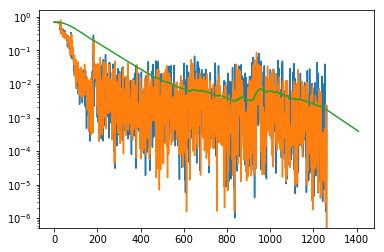

In [72]:
plt.semilogy(loss_v_history)
plt.semilogy(loss_history)
plt.plot(moving_loss_history)

# Dropout or not?  0.5 0.25 0.75

In [14]:
drop_prob = 0.75
pool_type='avg'
pool_size = 16
pool_stride= 2
# 64256 16
# 64704 8
# 64832 6
# 64960 4
# 65024 2
sl = 64256
act_type = 'relu' # 'relu' 'elu'
dilate_size = 1  # 2 63808
num_fc = 64
nf = 1
# 32128 1/2
# 128512 2
# 257024 4
address = 'dropout0_75'
# 15040
mkdir_checkdir(path = "./%s" %address)

./dropout0_75 have existed!


In [16]:
print('Start Training at SNR = %s ...' %str(1))
Info = Train(train = train_dict['1']
             ,test = test_dict['1'], Debug=True , params_init = None
             , batch_size=256, lr=0.003, epochs=100
             , smoothing_constant = .01, SNR = 1
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , act_type = act_type, dilate_size = dilate_size, nf = nf
             , num_fc = num_fc, num_outputs = 2, period = 256, net=net, init_params=init_params)

for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
    for key, value in {'params':params
#                                  , 'loss_history': nd.array(loss_history)
#                                  , 'loss_v_history': nd.array(loss_v_history)
#                                  , 'moving_loss_history': nd.array(moving_loss_history)
#                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
#                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
                      }.items():

        nd.save("./%s/%s_%s" %(address,key,index+1), value)

Start Training at SNR = 1 ...
Label for training: (19712,)
Dataset for training: (19712, 8192)

Label for testing: (19136,)
Dataset for testing: (19136, 8192)

Initiate weights from random...
Debuging...
h1 shape: [ 256   16    1 4081]
h2 shape: [ 256   32    1 2030]
h3 shape: [ 256   64    1 1004]
Flat h4 shape: [  256 64256]
h5 shape: [256  64]
Dropout:  0.75
yhat_linear shape: [256   2]

pool_type:  avg
pool_size:  16
pool_stride:  2
sl:  64256
act_type:  relu
dilate_size: (1, 1)
num_filter:  1
Epoch 1, Moving_loss: 0.553718, Epoch_loss(mean): 0.464024, Train_acc 0.9876, Test_acc 0.9874
Epoch 2, Moving_loss: 0.329100, Epoch_loss(mean): 0.129649, Train_acc 0.9980, Test_acc 0.9976
Epoch 3, Moving_loss: 0.161908, Epoch_loss(mean): 0.014660, Train_acc 0.5000, Test_acc 0.5003
Epoch 4, Moving_loss: 0.076962, Epoch_loss(mean): 0.000000, Train_acc 0.5000, Test_acc 0.5003
Epoch 5, Moving_loss: 0.036583, Epoch_loss(mean): 0.000000, Train_acc 0.5000, Test_acc 0.5001
Epoch 6, Moving_loss: 0.017

KeyboardInterrupt: 